In [9]:
# modules required for handling dataframes
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
import itertools
import seaborn as sns
from decimal import Decimal

In [10]:
#count pivot table of dataframe with taxonomic columns: 
#rows - rank names, columns - barcode, sorted by desired class
def generate_ncbi_taxonomy_pivot_k2(tax_df, rank, bcs, num):
    """From tax_df, generate a pivot table listing num rank counts, sorted by bcs"""
    pivot_table = tax_df.pivot_table(values='seq_length_k2', 
                                            index=rank, 
                                            columns='superkingdom_k2', 
                                            aggfunc='sum', 
                                            fill_value=0)
    pivot_table.columns.name = None
    pivot_table = pivot_table.sort_values(bcs, axis=0, ascending=False).head(n=num)
    return pivot_table


#count pivot table of dataframe with taxonomic columns: 
#rows - rank names, columns - barcode, sorted by desired class
def generate_ncbi_taxonomy_pivot_minimap(tax_df, rank, bcs, num):
    """From tax_df, generate a pivot table listing num rank counts, sorted by bcs"""
    pivot_table = tax_df.pivot_table(values='seqlen', 
                                            index=rank, 
                                            columns='kingdom', 
                                            aggfunc='count', 
                                            fill_value=0)
    pivot_table.columns.name = None
    pivot_table = pivot_table.sort_values(bcs, axis=0, ascending=False).head(n=num)
    return pivot_table

def add_df_headers(df, header_list):
    df.columns = header_list

def trim_df_columns(df,column_list):
    df.drop(columns=column_list, inplace=True)

In [11]:
# Define some global variables.
sourcedir = '/home/yiheng/MinION_data/' # the directory where all the documents of each sequencing run are stored.
genera_in_mock = ['Aspergillus','Blastobotrys','Candida','Diutina', 'Nakaseomyces', 'Clavispora','Cryptococcus','Cyberlindnera',
'Debaryomyces','Geotrichum','Kluyveromyces','Kodamaea','Lomentospora','Magnusiomyces','Meyerozyma','Pichia',
'Rhodotorula','Scedosporium','Trichophyton', 'Trichosporon', 'Wickerhamomyces','Yarrowia','Zygoascus', 'Purpureocillium']
fungal_phylums = ['Blastocladiomycota', 'Chytridiomycota', 'Glomeromycota', 'Microsporidia', 
                  'Neocallimastigomycota', 'Ascomycota', 'Basidiomycota', 'Mucoromycota']

In [12]:
def get_tab(seq_tech, sample, db, algorithm):
    if sample == 'IE':
        barcode = '05'
    elif sample == 'MC':
        barcode = '06'
    else:
        print('wrong sample name.')
        
    if seq_tech == 'nanopore':
        blast_tab_path = os.path.join(sourcedir, 'barcode%s' % barcode, 'barcode%s.%sdb_%s.tab' % (barcode, db, algorithm))
        blast_tab_df = pd.read_csv(blast_tab_path, sep='\t', index_col=0, header=0)
    elif seq_tech == 'illumina':
        blast_tab_path = os.path.join(sourcedir, 'mock_com/illumina', '%s1' % sample, 'finaldf.%s1.%s.%s.tab' % (sample, db, algorithm))
        blast_tab_df = pd.read_csv(blast_tab_path, sep='\t', index_col=0, header=0)
    else:
        print('''Check again your barcode, db or algorithm.
        sample must be chosen from 'IE' or 'MC'.
        db must be from 'nt' or 'refseq_fungi_updated'.
        algorithm must be from 'blast' or 'k2'.''')
    return blast_tab_df

In [13]:
# The next step is to calculate the precision and recall rates for each analysis
# For kraken data, the finaldf included all the unclassified reads/contig, so we could calculate recall rates straightaway.
# For blast data, the finaldf only included the classified reads, so we need to call the corresponding kraken finaldf to get the total length of each sample (from reads with Q>7)
# There are quite few if conditions in the function. This is because the final dataframe (tab file) are not consistantly generated.
# This function set an example of how to deal with inconsistant dataframe.
# I could clean up the final tab file from each analysis because I generated those files,
# but this kind of conditions can be useful if the tab file were generated by others.
# Nevertheless, this is a bad function.
def calculate_precision_recall_rates(seq_tech, sample, db, algorithm):
    tab_df = get_tab(seq_tech, sample, db, algorithm)
    if algorithm == 'k2':
        if seq_tech == 'nanopore':
            tab_df_classified = tab_df[tab_df.taxid_k2 != 0]
            tab_df_classified_true = tab_df_classified[tab_df_classified.genus_k2.isin(genera_in_mock)]
            recall_rate = tab_df_classified.seq_length_k2.sum()/tab_df.seq_length_k2.sum()
            precision_rate = tab_df_classified_true.seq_length_k2.sum()/tab_df_classified.seq_length_k2.sum()
        elif seq_tech == 'illumina':
            tab_df_classified = tab_df[tab_df.taxid != 0]
            tab_df_classified_true = tab_df_classified[tab_df_classified.genus.isin(genera_in_mock)]
            recall_rate = tab_df_classified.total_cov.sum()/tab_df.total_cov.sum()
            precision_rate = tab_df_classified_true.total_cov.sum()/tab_df_classified.total_cov.sum()
        else:
            print('check the sequencing tech you typed in.')
            
    elif algorithm == 'blast':
        # this k2 df is used for capture the sequencing length or total coverage.
        if db == 'refseq_fungi_updated':
            tab_df_k2 = get_tab(seq_tech, sample, 'fungi', 'k2')
        else:
            tab_df_k2 = get_tab(seq_tech, sample, db, 'k2')
        
        
        if seq_tech == 'nanopore':
            tab_df_classified = tab_df[(tab_df.superkingdom_blast != 'Unclassified') & (~tab_df.superkingdom_blast.isna())]
            tab_df_classified_true = tab_df_classified[tab_df_classified.genus_blast.isin(genera_in_mock)]
            subset_tab_df_k2 = tab_df_k2[tab_df_k2.read_id_k2.isin(tab_df_classified.qseqid_blast)]
            subset_tab_df_k2_true = tab_df_k2[tab_df_k2.read_id_k2.isin(tab_df_classified_true.qseqid_blast)]
            recall_rate = subset_tab_df_k2.seq_length_k2.sum()/tab_df_k2.seq_length_k2.sum()
            precision_rate = subset_tab_df_k2_true.seq_length_k2.sum()/subset_tab_df_k2.seq_length_k2.sum()
        elif seq_tech == 'illumina':
            tab_df_classified = tab_df[(tab_df.superkingdom != 'Unclassified') & (~tab_df.superkingdom.isna())]
            tab_df_classified_true = tab_df_classified[tab_df_classified.genus.isin(genera_in_mock)]
            subset_tab_df_k2 = tab_df_k2[tab_df_k2.contig.isin(tab_df_classified.contig)]
            subset_tab_df_k2_true = tab_df_k2[tab_df_k2.contig.isin(tab_df_classified_true.contig)]
            recall_rate = subset_tab_df_k2.total_cov.sum()/tab_df_k2.total_cov.sum()
            precision_rate = subset_tab_df_k2_true.total_cov.sum()/subset_tab_df_k2.total_cov.sum()
        else:
            print('check the sequencing tech you typed in.')
    else:
        print('check the algorithm you typed in.')
    return (precision_rate, recall_rate)

In [14]:
MC_precision_recall = pd.DataFrame(columns=['Precision', 'Recall'])
MC_precision_recall.loc[0] = calculate_precision_recall_rates('illumina', 'MC', 'refseq_fungi_updated', 'blast')
MC_precision_recall.loc[1] = calculate_precision_recall_rates('illumina', 'MC', 'nt', 'blast')
MC_precision_recall.loc[2] = calculate_precision_recall_rates('nanopore', 'MC', 'refseq_fungi_updated', 'blast')
MC_precision_recall.loc[3] = calculate_precision_recall_rates('nanopore', 'MC', 'nt', 'blast')
MC_precision_recall.loc[4] = calculate_precision_recall_rates('illumina', 'MC', 'fungi', 'k2')
MC_precision_recall.loc[5] = calculate_precision_recall_rates('illumina', 'MC', 'nt', 'k2')
MC_precision_recall.loc[6] = calculate_precision_recall_rates('nanopore', 'MC', 'fungi', 'k2')
MC_precision_recall.loc[7] = calculate_precision_recall_rates('nanopore', 'MC', 'nt', 'k2')

/home/yiheng/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/home/yiheng/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/home/yiheng/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [15]:
IE_precision_recall = pd.DataFrame(columns=['Precision', 'Recall'])
IE_precision_recall.loc[0] = calculate_precision_recall_rates('illumina', 'IE', 'refseq_fungi_updated', 'blast')
IE_precision_recall.loc[1] = calculate_precision_recall_rates('illumina', 'IE', 'nt', 'blast')
IE_precision_recall.loc[2] = calculate_precision_recall_rates('nanopore', 'IE', 'refseq_fungi_updated', 'blast')
IE_precision_recall.loc[3] = calculate_precision_recall_rates('nanopore', 'IE', 'nt', 'blast')
IE_precision_recall.loc[4] = calculate_precision_recall_rates('illumina', 'IE', 'fungi', 'k2')
IE_precision_recall.loc[5] = calculate_precision_recall_rates('illumina', 'IE', 'nt', 'k2')
IE_precision_recall.loc[6] = calculate_precision_recall_rates('nanopore', 'IE', 'fungi', 'k2')
IE_precision_recall.loc[7] = calculate_precision_recall_rates('nanopore', 'IE', 'nt', 'k2')

/home/yiheng/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/home/yiheng/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/home/yiheng/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [16]:
IE_precision_recall['category'] = ['illumina+blast+fungi', 'illumina+blast+nt', 'nanopore+blast+fungi', 'nanopore+blast+nt',
                                   'illumina+kraken2+fungi', 'illumina+kraken2+nt', 'nanopore+kraken2+fungi', 'nanopore+kraken2+nt']
MC_precision_recall['category'] = ['illumina+blast+fungi', 'illumina+blast+nt', 'nanopore+blast+fungi', 'nanopore+blast+nt',
                                   'illumina+kraken2+fungi', 'illumina+kraken2+nt', 'nanopore+kraken2+fungi', 'nanopore+kraken2+nt']

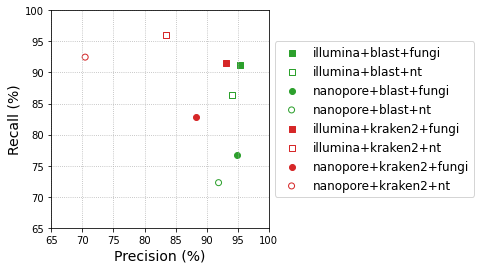

In [9]:
markers = ["s", "s", "o", "o", "s", "s", "o", "o"]
edgecolors = ['tab:green', 'tab:green', 'tab:green', 'tab:green', 'tab:red', 'tab:red', 'tab:red', 'tab:red']
facecolors = ['tab:green', 'none', 'tab:green', 'none', 'tab:red', 'none', 'tab:red', 'none']
for i in range(8): #for each of the 7 features 
    mi = markers[i] #marker for ith feature 
    xi = IE_precision_recall.Precision[i]*100 #x array for ith feature .. here is where you would generalize      different x for every feature
    yi = IE_precision_recall.Recall[i]*100 #y array for ith feature 
    ci = facecolors[i] #color for ith feature 
    di = edgecolors[i]
    ei = IE_precision_recall.category[i]
    plt.scatter(xi,yi,marker=mi, facecolors=ci, edgecolors=di, label=ei) 
    plt.legend(loc='center left', fontsize=12, bbox_to_anchor=(1, 0.5))
    plt.xlabel('Precision (%)', fontsize=14)
    plt.ylabel('Recall (%)', fontsize=14)
    plt.xlim([65, 100])
    plt.ylim([65, 100])
    ax = plt.gca()
    ax.xaxis.grid(linestyle='dotted')
    ax.yaxis.grid(linestyle='dotted')
    ax.set_aspect('equal', adjustable='box')
plt.savefig(os.path.join(sourcedir, 'figures', 'IE_metagenomics_precision_recall_1.png'), bbox_inches='tight', dpi=600)   


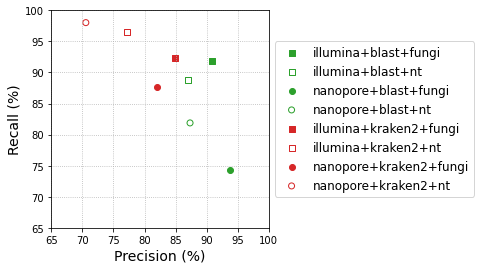

In [19]:
for i in range(8): #for each of the 7 features 
    mi = markers[i] #marker for ith feature 
    xi = MC_precision_recall.Precision[i]*100 #x array for ith feature .. here is where you would generalize      different x for every feature
    yi = MC_precision_recall.Recall[i]*100 #y array for ith feature 
    ci = facecolors[i] #color for ith feature 
    di = edgecolors[i]
    ei = IE_precision_recall.category[i]
    plt.scatter(xi,yi,marker=mi, facecolors=ci, edgecolors=di, label=ei) 
    plt.legend(loc='center left', fontsize=12, bbox_to_anchor=(1, 0.5))
    plt.xlabel('Precision (%)', fontsize=14)
    plt.ylabel('Recall (%)', fontsize=14)
    plt.xlim([65, 100])
    plt.ylim([65, 100])
    ax = plt.gca()
    ax.xaxis.grid(linestyle='dotted')
    ax.yaxis.grid(linestyle='dotted')
    ax.set_aspect('equal', adjustable='box')
plt.savefig(os.path.join(sourcedir, 'figures', 'MC_metagenomics_precision_recall_1.png'), bbox_inches='tight', dpi=600)   

In [17]:
def calculate_concordance_algorithmfixed(seq_tech, sample, algorithm):
    if algorithm == 'blast':
        fungi_df = get_tab(seq_tech, sample, 'refseq_fungi_updated', algorithm)
    elif algorithm == 'k2':
        fungi_df = get_tab(seq_tech, sample, 'fungi', algorithm)
    else:
        print('Wrong db name.')
    nt_df = get_tab(seq_tech, sample, 'nt', algorithm)
    
    if seq_tech == 'illumina':
        fungi_df.columns = ['%s_fungi' % x for x in fungi_df.columns]
        nt_df.columns = ['%s_nt' % x for x in nt_df.columns]
        merged_df = pd.merge(fungi_df, nt_df, how="outer", left_on='contig_fungi', right_on='contig_nt')
        # This line is only for the k2 algorithm, 
        # As the blast of illumina data has already removed the unmapped contigs.
        merged_df_trimed = merged_df[~merged_df.total_cov_fungi.isna()]
        # For simplicity, it doesn't need to drop any colomns
        # As we have already dropped NaN rows in the total_cov column so we can quickly fill the rest of columns with na
        merged_df_trimed = merged_df_trimed.fillna(value='unclassified')
        # This is the column that is used for sum up total length
        column_to_sum = 'total_cov_fungi'
    elif seq_tech == 'nanopore':
        if algorithm == 'blast':
            fungi_df.columns = [x[:-6] for x in fungi_df.columns]
            nt_df.columns = [x[:-6] for x in nt_df.columns]
            fungi_df.columns = ['%s_fungi' % x for x in fungi_df.columns]
            nt_df.columns = ['%s_nt' % x for x in nt_df.columns]
            merged_df = pd.merge(fungi_df, nt_df, how="outer", left_on='qseqid_fungi', right_on='qseqid_nt')
            # This is to fill the one column with the value from another
            merged_df['sequence_length_template_fungi'] = merged_df['sequence_length_template_fungi'\
                                                                   ].T.fillna(merged_df['sequence_length_template_nt']).T
            merged_df['qseqid_fungi'] = merged_df['qseqid_fungi'].T.fillna(merged_df['qseqid_nt']).T
            column_to_sum = 'sequence_length_template_fungi'
            merged_df_trimed = merged_df#.fillna(value='unclassified')
#            merged_df_trimed = merged_df_trimed[(merged_df_trimed.superkingdom_fungi != 'Unclassified') 
#                                                | (merged_df_trimed.superkingdom_nt != 'Unclassified')]
        elif algorithm == 'k2':
            fungi_df.columns = [x[:-3] for x in fungi_df.columns]
            nt_df.columns = [x[:-3] for x in nt_df.columns]
            fungi_df.columns = ['%s_fungi' % x for x in fungi_df.columns]
            nt_df.columns = ['%s_nt' % x for x in nt_df.columns]
            merged_df = pd.merge(fungi_df, nt_df, how="outer", left_on='read_id_fungi', right_on='read_id_nt')
            column_to_sum = 'seq_length_fungi'
            merged_df_trimed = merged_df#.fillna(value='unclassified')
            merged_df_trimed = merged_df_trimed[(merged_df_trimed.classification_fungi == 'C') 
                                                | (merged_df_trimed.classification_nt == 'C')]
        else:
            print('Wrong algorithm.')
    else:
        print('Wrong sequencing tech.')    
    
    # This is to get the reads that are classified into the species in the community by at least one algorithm
#    merged_df_trimed_overlapped = merged_df_trimed[(merged_df_trimed.genus_fungi.isin(genera_in_mock)) |
#                                                   (merged_df_trimed.genus_nt.isin(genera_in_mock))]

    # This is to only take the fungal reads for comparison
#    merged_df_trimed = merged_df_trimed[(merged_df_trimed.phylum_fungi.isin(fungal_phylums)) 
#                                                | (merged_df_trimed.phylum_nt.isin(fungal_phylums))]
#    merged_df_trimed = merged_df_trimed.reset_index(drop=True)
    
    # This is to get the reads/contigs that classified into the same genus
#    merged_df_trimed_agreed_classification = merged_df_trimed_overlapped[merged_df_trimed_overlapped.genus_fungi == 
#                                                                         merged_df_trimed_overlapped.genus_nt]
    merged_df_trimed_agreed_classification = merged_df_trimed[merged_df_trimed.genus_fungi == 
                                                              merged_df_trimed.genus_nt]    
    # This is to calculate the overlapped percentage of different algorithms against the same database
    concordance = merged_df_trimed_agreed_classification[column_to_sum].sum()/merged_df_trimed[column_to_sum].sum()
    
    return concordance

In [18]:
def trim_merged_df_mixed_algorithm(merged_df, seq_tech):
    trimed_merged_df = merged_df[(~merged_df.superkingdom_blast.isna()) 
                                  | (merged_df.classification_k2 == 'C')]
    if seq_tech == 'illumina':
        trimed_merged_df = trimed_merged_df.drop(columns=['len_blast', 'ave_cov_blast', 'total_cov_blast', 'evalue_blast', 
                                                   'pident_blast', 'pmatch_blast', 'len_k2', 'ave_cov_k2', 'classification_k2', 
                                                   'taxid_k2', 'seqlen_k2', 'kmer_profile_k2'])
        # all the contigs that has no coverage means they are false assembly. They won't contribute to the analysis so we get rid of them
        trimed_merged_df = trimed_merged_df[~trimed_merged_df.total_cov_k2.isna()]
    elif seq_tech == 'nanopore':
        trimed_merged_df = trimed_merged_df.drop(columns=['batch_id_blast', 'sequence_length_template_blast', 'scaling_median_template_blast', 
                                                   'scaling_mad_template_blast', 'pident_blast', 'nident_blast', 'staxids_blast', 'sscinames_blast', 
                                                   'log_evalue_blast', 'pmatch_blast', 'classification_k2', 'taxid_k2', 'kmer_profile_k2'])
    else:
        print('Data type not recognized. Can only recognize illumina or nanopore data.')
#    trimed_merged_df.superkingdom_blast = trimed_merged_df.superkingdom_blast.fillna(value='unclassified')
#    trimed_merged_df.phylum_blast = trimed_merged_df.phylum_blast.fillna(value='unclassified')
#    trimed_merged_df.class_blast = trimed_merged_df.class_blast.fillna(value='unclassified')
#    trimed_merged_df.order_blast = trimed_merged_df.order_blast.fillna(value='unclassified')
#    trimed_merged_df.family_blast = trimed_merged_df.family_blast.fillna(value='unclassified')
#    trimed_merged_df.genus_blast = trimed_merged_df.genus_blast.fillna(value='unclassified')
#    trimed_merged_df.species_blast = trimed_merged_df.species_blast.fillna(value='unclassified')
    trimed_merged_df = trimed_merged_df.reset_index(drop=True)
    return trimed_merged_df

In [19]:
def calculate_concordance_dbfixed(seq_tech, sample, db):
    if db == 'fungi':
        blast_df = get_tab(seq_tech, sample, 'refseq_fungi_updated', 'blast')
    elif db == 'nt':
        blast_df = get_tab(seq_tech, sample, db, 'blast')
    else:
        print('Wrong db name.')
    k2_df = get_tab(seq_tech, sample, db, 'k2')
    
    if seq_tech == 'illumina':
        blast_df.columns = ['%s_blast' % x for x in blast_df.columns]
        k2_df.columns = ['%s_k2' % x for x in k2_df.columns]
        merged_df = pd.merge(blast_df, k2_df, how="outer", left_on='contig_blast', right_on='contig_k2')
        # This is the column that is used for sum up total length
        column_to_sum = 'total_cov_k2'
    elif seq_tech == 'nanopore':
        merged_df = pd.merge(blast_df, k2_df, how="outer", left_on='qseqid_blast', right_on='read_id_k2')
        column_to_sum = 'seq_length_k2'
    else:
        print('Wrong sequencing tech.')
    
    # This is to first get the reads/contigs that were both classified by the algorithms
    # It's in the triming step.
    merged_df_trimed = trim_merged_df_mixed_algorithm(merged_df, seq_tech)
    
    # This is to get the reads that are classified into the species in the community by at least one algorithm
#    merged_df_trimed_overlapped = merged_df_trimed[(merged_df_trimed.genus_blast.isin(genera_in_mock)) |
#                                                   (merged_df_trimed.genus_k2.isin(genera_in_mock))]

    # This is to only take the fungal reads for comparison
#    merged_df_trimed = merged_df_trimed[(merged_df_trimed.phylum_blast.isin(fungal_phylums)) 
#                                                | (merged_df_trimed.phylum_k2.isin(fungal_phylums))]
#    merged_df_trimed = merged_df_trimed.reset_index(drop=True)

    # This is to get the reads/contigs that classified into the same genus
#    merged_df_trimed_agreed_classification = merged_df_trimed_overlapped[merged_df_trimed_overlapped.genus_blast == 
#                                                                         merged_df_trimed_overlapped.genus_k2]
    merged_df_trimed_agreed_classification = merged_df_trimed[merged_df_trimed.genus_blast == 
                                                              merged_df_trimed.genus_k2]    
    # This is to calculate the overlapped percentage of different algorithms against the same database
    
    concordance = merged_df_trimed_agreed_classification[column_to_sum].sum()/merged_df_trimed[column_to_sum].sum()
    
    return concordance

In [66]:
Classification_strategy_list = ['Same database different algorithm', 'Same database different algorithm', 'Same algorithm different database', 'Same algorithm different database']

In [67]:
illumina_IE_df = pd.DataFrame()
illumina_IE_df['Concordance'] = [calculate_concordance_algorithmfixed('illumina', 'IE', 'blast'),
                                 calculate_concordance_algorithmfixed('illumina', 'IE', 'k2'),
                                 calculate_concordance_dbfixed('illumina', 'IE', 'fungi'),
                                 calculate_concordance_dbfixed('illumina', 'IE', 'nt')]
illumina_IE_df['Classification strategy'] = Classification_strategy_list
illumina_IE_df['Sequencing strategy'] = 'PD-Illumina'

In [68]:
nanopore_IE_df = pd.DataFrame()
nanopore_IE_df['Concordance'] = [calculate_concordance_algorithmfixed('nanopore', 'IE', 'blast'),
                                calculate_concordance_algorithmfixed('nanopore', 'IE', 'k2'),
                                calculate_concordance_dbfixed('nanopore', 'IE', 'fungi'),
                                calculate_concordance_dbfixed('nanopore', 'IE', 'nt')]
nanopore_IE_df['Classification strategy'] = Classification_strategy_list
nanopore_IE_df['Sequencing strategy'] = 'PD-Nanopore'

/home/yiheng/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [69]:
illumina_MC_df = pd.DataFrame()
illumina_MC_df['Concordance'] = [calculate_concordance_algorithmfixed('illumina', 'MC', 'blast'),
                                 calculate_concordance_algorithmfixed('illumina', 'MC', 'k2'),
                                 calculate_concordance_dbfixed('illumina', 'MC', 'fungi'),
                                 calculate_concordance_dbfixed('illumina', 'MC', 'nt')]
illumina_MC_df['Classification strategy'] = Classification_strategy_list
illumina_MC_df['Sequencing strategy'] = ' PB-Illumina '

In [70]:
nanopore_MC_df = pd.DataFrame()
nanopore_MC_df['Concordance'] = [calculate_concordance_algorithmfixed('nanopore', 'MC', 'blast'),
                                calculate_concordance_algorithmfixed('nanopore', 'MC', 'k2'),
                                calculate_concordance_dbfixed('nanopore', 'MC', 'fungi'),
                                calculate_concordance_dbfixed('nanopore', 'MC', 'nt')]
nanopore_MC_df['Classification strategy'] = Classification_strategy_list
nanopore_MC_df['Sequencing strategy'] = ' PB-Nanopore '

In [71]:
concordance_df_combined = pd.concat([illumina_IE_df, nanopore_IE_df, illumina_MC_df, nanopore_MC_df], ignore_index=True)
concordance_df_combined.Concordance = concordance_df_combined.Concordance*100

In [45]:
mean_confordance_illumina_IE_algorithmfixed = (calculate_concordance_algorithmfixed('illumina', 'IE', 'blast') +
                                               calculate_concordance_algorithmfixed('illumina', 'IE', 'k2'))/0.02
mean_confordance_illumina_IE_dbfixed = (calculate_concordance_dbfixed('illumina', 'IE', 'fungi') +
                                        calculate_concordance_dbfixed('illumina', 'IE', 'nt'))/0.02
mean_confordance_nanopore_IE_algorithmfixed = (calculate_concordance_algorithmfixed('nanopore', 'IE', 'blast') +
                                               calculate_concordance_algorithmfixed('nanopore', 'IE', 'k2'))/0.02
mean_confordance_nanopore_IE_dbfixed = (calculate_concordance_dbfixed('nanopore', 'IE', 'fungi') +
                                        calculate_concordance_dbfixed('nanopore', 'IE', 'nt'))/0.02
mean_confordance_illumina_MC_algorithmfixed = (calculate_concordance_algorithmfixed('illumina', 'MC', 'blast') +
                                               calculate_concordance_algorithmfixed('illumina', 'MC', 'k2'))/0.02
mean_confordance_illumina_MC_dbfixed = (calculate_concordance_dbfixed('illumina', 'MC', 'fungi') +
                                        calculate_concordance_dbfixed('illumina', 'MC', 'nt'))/0.02
mean_confordance_nanopore_MC_algorithmfixed = (calculate_concordance_algorithmfixed('nanopore', 'MC', 'blast') +
                                               calculate_concordance_algorithmfixed('nanopore', 'MC', 'k2'))/0.02
mean_confordance_nanopore_MC_dbfixed = (calculate_concordance_dbfixed('nanopore', 'MC', 'fungi') +
                                        calculate_concordance_dbfixed('nanopore', 'MC', 'nt'))/0.02

/home/yiheng/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [53]:
concordance_df_combined

,Concordance,Classification strategy,Sequencing strategy
0,86.216179,Same algorithm,PD-Illumina
1,86.229983,Same algorithm,PD-Illumina
2,86.733424,Same database,PD-Illumina
3,83.490442,Same database,PD-Illumina
4,79.849853,Same algorithm,PD-Nanopore
5,70.925951,Same algorithm,PD-Nanopore
6,83.219497,Same database,PD-Nanopore
7,69.450897,Same database,PD-Nanopore
8,76.021434,Same algorithm,PB-Illumina
9,79.158508,Same algorithm,PB-Illumina


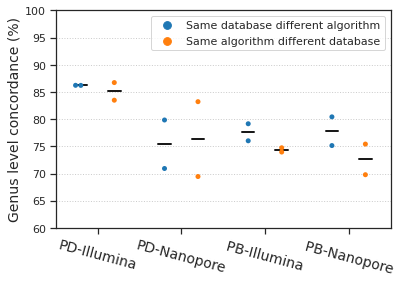

In [72]:
sns.set(style="ticks")
x_labels = ['PD-Illumina', 'PD-Nanopore', ' PB-Illumina ', ' PB-Nanopore ']
x_pos = np.arange(len(x_labels))


ax = sns.swarmplot(x="Sequencing strategy", y="Concordance", hue='Classification strategy', edgecolor='1',
                   data=concordance_df_combined, palette="tab10", dodge=True)
ax.set_xlabel(' ', fontsize=14)
ax.yaxis.grid(linestyle='dotted')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[2:], labels=labels[2:])
ax.set_xticklabels(x_labels, fontsize=14)
plt.xticks(rotation=-15)
ax.yaxis.set_label_text('Genus level concordance (%)', fontsize=14)
plt.ylim(60, 100)
# This is to plot the average/mean lines for each sample
ax.plot([-0.275,-0.125], [mean_confordance_illumina_IE_algorithmfixed,mean_confordance_illumina_IE_algorithmfixed], lw=2, color='k')
ax.plot([0.125,0.275], [mean_confordance_illumina_IE_dbfixed,mean_confordance_illumina_IE_dbfixed], lw=2, color='k')
ax.plot([0.725,0.875], [mean_confordance_nanopore_IE_algorithmfixed,mean_confordance_nanopore_IE_algorithmfixed], lw=2, color='k')
ax.plot([1.125,1.275], [mean_confordance_nanopore_IE_dbfixed,mean_confordance_nanopore_IE_dbfixed], lw=2, color='k')
ax.plot([1.725,1.875], [mean_confordance_illumina_MC_algorithmfixed,mean_confordance_illumina_MC_algorithmfixed], lw=2, color='k')
ax.plot([2.125,2.275], [mean_confordance_illumina_MC_dbfixed,mean_confordance_illumina_MC_dbfixed], lw=2, color='k')
ax.plot([2.725,2.875], [mean_confordance_nanopore_MC_algorithmfixed,mean_confordance_nanopore_MC_algorithmfixed], lw=2, color='k')
ax.plot([3.125,3.275], [mean_confordance_nanopore_MC_dbfixed,mean_confordance_nanopore_MC_dbfixed], lw=2, color='k')

#plt.show()
plt.savefig(os.path.join(sourcedir, 'figures', 'Figure1A_all_reads.png'), bbox_inches="tight", dpi=1000)

In [79]:
nanopore_MC_fungi_blast_df.columns = ['%s_fungi' % x for x in nanopore_MC_fungi_blast_df.columns]
nanopore_MC_nt_blast_df.columns = ['%s_nt' % x for x in nanopore_MC_nt_blast_df.columns]
nanopore_MC_blast_df = pd.merge(nanopore_MC_fungi_blast_df, nanopore_MC_nt_blast_df, 
                                how="outer", 
                                left_on='qseqid_blast_fungi', 
                                right_on='qseqid_blast_nt')

In [80]:
def trim_merged_df_blast(merged_df, seq_tech):
    trimed_merged_df = merged_df[(~merged_df.superkingdom_blast_fungi.isna()) 
                                  | ~merged_df.superkingdom_blast_nt.isna()]
    if seq_tech == 'illumina':
        trimed_merged_df = merged_df.drop(columns=['len_blast', 'ave_cov_blast', 'total_cov_blast', 'evalue_blast', 
                                                   'pident_blast', 'pmatch_blast', 'len_k2', 'ave_cov_k2', 'classification_k2', 
                                                   'taxid_k2', 'seqlen_k2', 'kmer_profile_k2',])
        # all the contigs that has no coverage means they are false assembly. They won't contribute to the analysis so we get rid of them
        trimed_merged_df = trimed_merged_df[~trimed_merged_df.total_cov_k2.isna()]
    elif seq_tech == 'nanopore':
        trimed_merged_df = merged_df[(~merged_df.superkingdom_blast_fungi.isna()) 
                                      | ~merged_df.superkingdom_blast_nt.isna()]
        trimed_merged_df = trimed_merged_df.drop(columns=['batch_id_blast_fungi',  'scaling_median_template_blast_fungi',
                                                   'scaling_mad_template_blast_fungi', 'pident_blast_fungi', 'nident_blast_fungi', 'staxids_blast_fungi',
                                                   'sscinames_blast_fungi', 'log_evalue_blast_fungi', 'pmatch_blast_fungi', 'batch_id_blast_nt', 'scaling_median_template_blast_nt',
                                                   'scaling_mad_template_blast_nt', 'qseqid_blast_nt', 'pident_blast_nt',
                                                   'nident_blast_nt', 'staxids_blast_nt', 'sscinames_blast_nt',
                                                   'log_evalue_blast_nt', 'pmatch_blast_nt'])
    else:
        print('Data type not recognized. Can only recognize illumina or nanopore data.')
    trimed_merged_df.superkingdom_blast_fungi = trimed_merged_df.superkingdom_blast_fungi.fillna(value='Unclassified')
    trimed_merged_df.phylum_blast_fungi = trimed_merged_df.phylum_blast_fungi.fillna(value='Unclassified')
    trimed_merged_df.class_blast_fungi = trimed_merged_df.class_blast_fungi.fillna(value='Unclassified')
    trimed_merged_df.order_blast_fungi = trimed_merged_df.order_blast_fungi.fillna(value='Unclassified')
    trimed_merged_df.family_blast_fungi = trimed_merged_df.family_blast_fungi.fillna(value='Unclassified')
    trimed_merged_df.genus_blast_fungi = trimed_merged_df.genus_blast_fungi.fillna(value='Unclassified')
    trimed_merged_df.species_blast_fungi = trimed_merged_df.species_blast_fungi.fillna(value='Unclassified')
    trimed_merged_df.superkingdom_blast_nt = trimed_merged_df.superkingdom_blast_nt.fillna(value='Unclassified')
    trimed_merged_df.phylum_blast_nt = trimed_merged_df.phylum_blast_nt.fillna(value='Unclassified')
    trimed_merged_df.class_blast_nt = trimed_merged_df.class_blast_nt.fillna(value='Unclassified')
    trimed_merged_df.order_blast_nt = trimed_merged_df.order_blast_nt.fillna(value='Unclassified')
    trimed_merged_df.family_blast_nt = trimed_merged_df.family_blast_nt.fillna(value='Unclassified')
    trimed_merged_df.genus_blast_nt = trimed_merged_df.genus_blast_nt.fillna(value='Unclassified')
    trimed_merged_df.species_blast_nt = trimed_merged_df.species_blast_nt.fillna(value='Unclassified')
    trimed_merged_df = trimed_merged_df.reset_index(drop=True)
    return trimed_merged_df

In [81]:
trimed_nanopore_MC_blast_shared = trim_merged_df_blast(nanopore_MC_blast_df, 'nanopore')

In [82]:
trimed_nanopore_MC_blast_shared_1 = trimed_nanopore_MC_blast_shared[trimed_nanopore_MC_blast_shared.sequence_length_template_blast_fungi.isna()]
trimed_nanopore_MC_blast_shared_2 = trimed_nanopore_MC_blast_shared[trimed_nanopore_MC_blast_shared.sequence_length_template_blast_nt.isna()]
trimed_nanopore_MC_blast_shared_3 = trimed_nanopore_MC_blast_shared[(~trimed_nanopore_MC_blast_shared.sequence_length_template_blast_fungi.isna()
                                                                    & (~trimed_nanopore_MC_blast_shared.sequence_length_template_blast_nt.isna()))]

In [83]:
trimed_nanopore_MC_blast_shared_1.sequence_length_template_blast_fungi = trimed_nanopore_MC_blast_shared_1.sequence_length_template_blast_nt
trimed_nanopore_MC_blast_shared_2.sequence_length_template_blast_nt = trimed_nanopore_MC_blast_shared_1.sequence_length_template_blast_fungi

/home/yiheng/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [84]:
trimed_nanopore_MC_blast_shared_final = pd.concat([trimed_nanopore_MC_blast_shared_1,trimed_nanopore_MC_blast_shared_2, trimed_nanopore_MC_blast_shared_3], ignore_index=False)
trimed_nanopore_MC_blast_shared_final = trimed_nanopore_MC_blast_shared_final.sort_index()

In [85]:
trimed_nanopore_MC_blast_shared_final['source'] = trimed_nanopore_MC_blast_shared_final.genus_blast_fungi
trimed_nanopore_MC_blast_shared_final['target'] = trimed_nanopore_MC_blast_shared_final.genus_blast_nt
trimed_nanopore_MC_blast_shared_final['value'] = trimed_nanopore_MC_blast_shared_final.sequence_length_template_blast_fungi

In [98]:
overlapped_trimed_nanopore_MC_blast_shared_final = trimed_nanopore_MC_blast_shared_final[(trimed_nanopore_MC_blast_shared_final.source.isin(genera_in_mock)) |
                                                                      (trimed_nanopore_MC_blast_shared_final.target.isin(genera_in_mock))]

In [99]:
fungi_dataset = Dataset(overlapped_trimed_nanopore_MC_blast_shared_final)

In [100]:
nodes = {
    'genera_blast_fungi': ProcessGroup(overlapped_trimed_nanopore_MC_blast_shared_final.genus_blast_fungi.tolist()),
    'genera_blast_nt': ProcessGroup(overlapped_trimed_nanopore_MC_blast_shared_final.genus_blast_nt.tolist()),
}

ordering = [
    ['genera_blast_fungi'],       # put "farms" on the left...
    ['genera_blast_nt']   # ... and "customers" on the right.
]
bundles = [
    Bundle('genera_blast_fungi', 'genera_blast_nt')
]
sdd = SankeyDefinition(nodes, bundles, ordering)

blast_fungi_genera_with_other = Partition.Simple('process', [
     'Unclassified', ('Shared genera', ['Aspergillus','Blastobotrys','Candida','Diutina', 'Nakaseomyces', 'Clavispora','Cryptococcus','Cyberlindnera',
'Debaryomyces','Geotrichum','Kluyveromyces','Kodamaea','Lomentospora','Magnusiomyces','Meyerozyma','Pichia',
'Rhodotorula','Scedosporium','Trichophyton', 'Trichosporon', 'Wickerhamomyces','Yarrowia','Zygoascus', 'Purpureocillium']) ])   # ... or a group

blast_nt_genera_genera_with_other = Partition.Simple('process', [
    'Unclassified',('Shared genera', ['Aspergillus','Blastobotrys','Candida','Diutina', 'Nakaseomyces', 'Clavispora','Cryptococcus','Cyberlindnera',
'Debaryomyces','Geotrichum','Kluyveromyces','Kodamaea','Lomentospora','Magnusiomyces','Meyerozyma','Pichia',
'Rhodotorula','Scedosporium','Trichophyton', 'Trichosporon', 'Wickerhamomyces','Yarrowia','Zygoascus', 'Purpureocillium']) # ... or a group
])

In [101]:
nodes['genera_blast_fungi'].partition = blast_fungi_genera_with_other
nodes['genera_blast_nt'].partition = blast_nt_genera_genera_with_other

In [121]:
size = dict(width=400, height=200)
weave(sdd, fungi_dataset).to_widget(**size).auto_save_svg('/home/yiheng/MinION_data/figures/Figure1_blast_fungi_nt.svg')

SankeyWidget(groups=[{'id': 'genera_blast_fungi', 'type': 'process', 'title': '', 'nodes': ['genera_blast_fung…